In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import DataFrame
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [26]:
# Load data
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Explore categorical data
* MSZoning: Identifies the general zoning classification of the sale

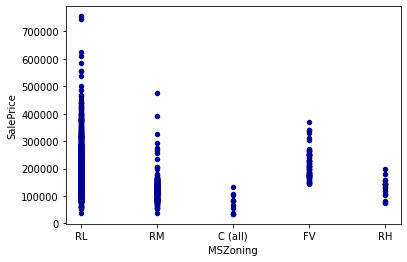

In [27]:
# Visualize features
def _plot(feature):
    train_df.plot.scatter(x=feature,
                          y='SalePrice',
                          c='DarkBlue')

_plot('MSZoning')

# Encode - MSZoning: Identifies the general zoning classification of the sale. - One hot encoding
# Train data
MSZoning = pd.get_dummies(train_df.MSZoning, prefix='MSZoning', drop_first=True)
train_df = pd.concat([train_df, MSZoning], axis=1)
train_df.drop('MSZoning', axis=1, inplace=True)
# Test data
MSZoning = pd.get_dummies(test_df.MSZoning, prefix='MSZoning', drop_first=True)
test_df = pd.concat([test_df, MSZoning], axis=1)
test_df.drop('MSZoning', axis=1, inplace=True)


**Explore Garage related features:**


GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage

In [28]:
# Encode - GarageType: Garage location - One hot encoding
# Train data
GarageType = pd.get_dummies(train_df.GarageType, prefix='GarageType', drop_first=True)
train_df = pd.concat([train_df, GarageType], axis=1)
train_df.drop('GarageType', axis=1, inplace=True)
# Test data
GarageType = pd.get_dummies(test_df.GarageType, prefix='GarageType', drop_first=True)
test_df = pd.concat([test_df, GarageType], axis=1)
test_df.drop('GarageType', axis=1, inplace=True)

GarageYrBlt: Year garage was built

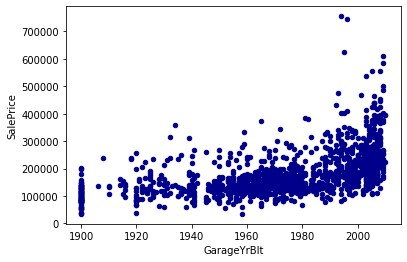

In [29]:
#GarageYrBlt: Year garage was built
# Clean data - replace nan with minimum values:1900
train_df.GarageYrBlt.replace(np.nan, 1900, inplace=True)
test_df.GarageYrBlt.replace(np.nan, 1900, inplace=True)
_plot('GarageYrBlt')

GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

In [30]:
# Clean GarageFinish
train_df.GarageFinish.replace(np.nan, "NA", inplace=True)
test_df.GarageFinish.replace(np.nan, "NA", inplace=True)

# Encode - GarageFinish - Interior finish of the garage
def encode_GarageFinish(_str):
    GarageFinish_dict = {
        "Fin": 3,
        "RFn": 2,
        "Unf": 1,
        "NA": 0
    }
    return GarageFinish_dict[_str]

train_df['GarageFinish'] = train_df['GarageFinish'].apply(encode_GarageFinish)
test_df['GarageFinish'] = test_df['GarageFinish'].apply(encode_GarageFinish)

In [31]:
# Feature type categorization
categorical_features_list = train_df.select_dtypes(include='object').columns.tolist()
numerical_features_list = train_df.select_dtypes(include=np.number).columns.tolist()
all_feature_list = categorical_features_list + numerical_features_list
len(all_feature_list), len(categorical_features_list), len(numerical_features_list)

(88, 40, 48)

In [32]:
# Filter numerical features
train_df = train_df[numerical_features_list]
numerical_features_list.remove('SalePrice')
test_df = test_df[numerical_features_list]

In [33]:
print(train_df.shape)
# Replace empty string with NAN
train_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
test_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
print(train_df.shape)
# Fill NA with column mean
train_df.fillna(train_df.mean(), inplace=True)
test_df.fillna(test_df.mean(), inplace=True)
print(train_df.shape)
print(test_df.shape)
print("Selected feature set for modelling \n", train_df.columns)

(1460, 48)
(1460, 48)
(1460, 48)
(1459, 47)
Selected feature set for modelling 
 Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice',
       'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
       'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn',
       'GarageType_CarPort', 'GarageType_Detchd'],
      dtype='object')


In [34]:
# Seperate features and target
train_y = train_df['SalePrice']
train_x = train_df.drop(columns=['SalePrice'])
# Change the test df name for consistency
test_x = test_df.copy()
#train_y.describe()
train_x.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,YrSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,2008,0,0,1,0,1,0,0,0,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,2007,0,0,1,0,1,0,0,0,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,2008,0,0,1,0,1,0,0,0,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,2006,0,0,1,0,0,0,0,0,1
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,2008,0,0,1,0,1,0,0,0,0


In [35]:
# Separate train and validation sets
# train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, random_state = 0)
# len(train_x), len(val_x), len(train_y), len(val_y)

In [36]:
#Drop Id column since all are unique values
# print('Before...')
# print('Train  columns :', list(train_x.columns))
# print('Test columns :', list(test_x.columns))

train_x = train_x.drop(['Id'], axis=1)
# val_x = val_x.drop(['Id'], axis=1)
test_x = test_x.drop(['Id'], axis=1)

# print('\nAfter...')
# print('Train columns :', list(train_x.columns))
# print('Test columns :', list(test_x.columns))

### Normalization

In [37]:
from sklearn.preprocessing import StandardScaler
print(train_x.head())
# Standardizing the features
train_x_list = StandardScaler().fit_transform(train_x)
train_x = DataFrame(data = train_x_list, columns = train_x.columns)
print(train_x.head())

   MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  YrSold  MSZoning_FV  \
0          2003       196.0         706           0  ...    2008            0   
1          1976         0.0         978           0  ...    2007            0   
2          2002       162.0         486           0  ...    2008            0   
3          1970         0.0         216           0  ...    2006            0   
4          2000       350.0         655           0  ...    2008            0   

   MSZoning_RH  MSZoning_RL  MSZoning_RM  GarageType_Att

In [38]:
# # Scaling Data
# def min_max_scaling(df):
#     for column in df.columns:
#         df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
#     return df
# print(train_x.head())
# train_x = min_max_scaling(train_x)
# print(train_x.head())

### Train model

In [39]:
# Train model and check accuracy
def train_accuracy(model_pipe):
    model_pipe.fit(train_x, train_y)
    
    # Testing figures
    train_accuracy = model_pipe.score(train_x, train_y)
    print("Train accuracy", train_accuracy)
    
    pred = model_pipe.predict(train_x)
    rmse = np.sqrt(mean_squared_error(pred, train_y))
    print(f"Train RMSE: {rmse}")

#### MLPRegressor Model

In [40]:
# MLPRegressor_pipe = make_pipeline(PCA(n_components=30),
#                      MLPRegressor(random_state=1, max_iter=3000, hidden_layer_sizes=(100, 100),
#                                   verbose=False))
# train_accuracy(MLPRegressor_pipe)

Train accuracy 0.9511044498761438
Train RMSE: 17560.577934553017


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#### RandomForest Model

In [41]:
RandomForest_train_pipe = make_pipeline(RandomForestRegressor(random_state=1))
train_accuracy(RandomForest_train_pipe)

Train accuracy 0.9822172296186736
Train RMSE: 10590.192314440603


In [42]:
# def validation(model_pipe):
#     pred_y = model_pipe.predict(val_x)
#     val_rmse = np.sqrt(mean_squared_error(pred_y, val_y))
#     print(f"Validation RMSE: {val_rmse}")

# validation(MLPRegressor_pipe)
# validation(RandomForest_pipe)

Selected RandomForestRegressor model since it is faster and had higher training accuracy

In [43]:
# Train selected model
RandomForest_test = RandomForestRegressor(random_state=1)
RandomForest_test.fit(train_x, train_y)
print("Train score: ", RandomForest_test.score(train_x, train_y))
# Prediction for test data
test_prediction = RandomForest_test.predict(test_x)
print("Test predictions: ", test_prediction)

Train score:  0.9822172296186736
Test predictions:  [377289.6  362077.34 558332.41 ... 371355.99 325881.72 579328.04]


In [44]:
# Submission
def create_submission_file(test_prediction):
    test_results = DataFrame({
        'Id': test_df.Id,
        'SalePrice': test_prediction
    })
    print(test_results)
    test_results.to_csv('submission.csv', index=False)


create_submission_file(test_prediction)

        Id  SalePrice
0     1461  377289.60
1     1462  362077.34
2     1463  558332.41
3     1464  579328.04
4     1465  363810.73
...    ...        ...
1454  2915  528744.44
1455  2916  547659.58
1456  2917  371355.99
1457  2918  325881.72
1458  2919  579328.04

[1459 rows x 2 columns]
